In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('model.csv')

In [3]:
df.head()

,Unnamed: 0,sim_content,sin_comment,word_count,duplicate_word_ratio,no_of_sentences,length_of_comment,num_of_punctuations,is_period_sequence,stop_word_ratio,post_coment_gap,black_word_count,is_link,is_youtube_link,is_number,comment_duplication,classifier_val
0,0,0.265999,-0.885466,1.402002,0.000000,1,3.142169,0.0,0,0.0,19.075011,1.0,0,0,0,0.0,0
1,1,0.327123,-0.922096,2.768422,0.000000,1,4.917200,0.0,0,0.0,19.075011,0.0,0,0,0,0.0,0
2,2,0.433972,-0.746774,3.531449,0.032258,1,5.735184,0.0,0,0.0,19.075011,4.0,0,0,0,0.0,0
3,3,0.201993,-1.008426,1.818057,0.000000,1,3.777639,0.0,0,0.0,19.075011,0.0,0,0,0,0.0,1
4,4,0.176263,-1.131799,1.402002,0.000000,1,3.015984,0.0,0,0.0,19.075011,0.0,0,0,0,0.0,0


In [4]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sin_comment', 'word_count',
       'duplicate_word_ratio', 'no_of_sentences', 'length_of_comment',
       'num_of_punctuations', 'is_period_sequence', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'is_link', 'is_youtube_link',
       'is_number', 'comment_duplication', 'classifier_val'],
      dtype='object')

#### Standardization  is no need for xgboost

In [5]:
dfc = df.copy()

In [6]:
y = dfc['is_spam']
X = dfc.drop(['is_spam','id'],axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Handle imbalnce dataset (here we gonna use oversampling instead of smotec)

In [8]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(0.9)
X_train_ns,y_train_ns=os.fit_sample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

X_train = X_train_ns
y_train = y_train_ns

The number of classes before fit Counter({0: 6898, 1: 546})
The number of classes after fit Counter({0: 6898, 1: 6208})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.9 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


#### Hyperparameter Tuninng


In [9]:
from xgboost import XGBClassifier

In [10]:
xgb = XGBClassifier()

In [11]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [12]:
grid = {
    
    'max_depth':range(3,50),
 'min_child_weight':range(1,20),
 'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [13]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [15]:
xgb_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=XGBClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': range(3, 50),
                                        'min_child_weight': range(1, 20),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   return_train_score=True, scoring='accuracy', verbose=2)

#### Evaluvate

In [16]:
best_model = xgb_random.best_estimator_

In [17]:
best_model

XGBClassifier(colsample_bytree=0.7, gamma=0.2, max_depth=39, reg_alpha=0.01,
              subsample=0.9)

In [18]:
xgb_random.best_params_

{'subsample': 0.9,
 'reg_alpha': 0.01,
 'min_child_weight': 1,
 'max_depth': 39,
 'gamma': 0.2,
 'colsample_bytree': 0.7}

In [19]:
xgb_random.best_score_

0.9936670334981164

In [20]:
y_pred = best_model.predict(X_test)

In [21]:
err  =(y_pred- y_test)

<AxesSubplot:>

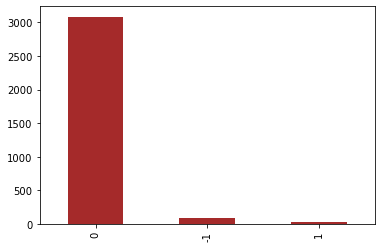

In [22]:
err.value_counts().plot(kind='bar',color='brown')

In [23]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.03321842682544657
MSE: 0.03321842682544657
RMSE: 0.1822592297400781


Text(0, 0.5, 'Feature Importance Score')

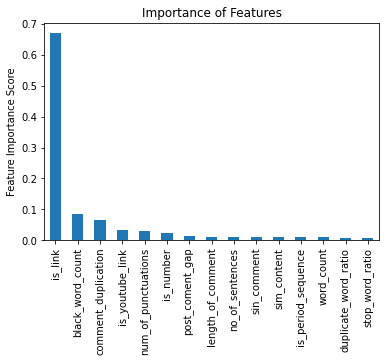

In [24]:
indices=list(X_train)
feat_imp = pd.Series(best_model.feature_importances_, indices).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2906   27]
 [  79  179]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2933
           1       0.87      0.69      0.77       258

    accuracy                           0.97      3191
   macro avg       0.92      0.84      0.88      3191
weighted avg       0.97      0.97      0.97      3191



In [26]:
print("accuracy is {}".format(best_model.score(X_test, y_test)))

accuracy is 0.9667815731745534


In [27]:
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)

### ROC

In [28]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [29]:
baseline_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

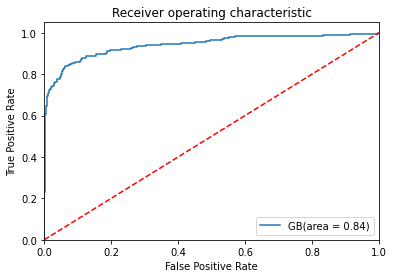

In [30]:
plt.figure()
plt.plot(fprB, tprB, label='GB(area = %0.2f)' % baseline_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()